# Single Image DR-GAN デモ

1. CFP 顔画像データセットの前処理，入力データの作成
2. Single Image DR-GANモデルの定義
3. 学習の定義
4. パラメータ指定，学習の実行
5. 学習結果の読み込み， 画像の生成

## 1. CFP 顔画像データセットの前処理，入力データの作成

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import glob
import numpy as np
from skimage import io, transform
from matplotlib import pylab as plt
%matplotlib inline
from tqdm import tqdm
import pdb

In [4]:
# CFP の画像を 長辺を指定した長さに， 短辺は 変換後に リサイズするクラス

class Resize(object):
    #  assume image  as H x W x C numpy array
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
        
    def __call__(self, image):
        h, w = image.shape[:2]
        if h > w:
            new_h, new_w = self.output_size, int(self.output_size * w / h)
        else:
            new_h, new_w = int(self.output_size * h / w), self.output_size

        resized_image = transform.resize(image, (new_h, new_w))
        
        if h>w:
            diff = self.output_size - new_w
            if diff%2 == 0:
                pad_l = int(diff/2)
                pad_s = int(diff/2)
            else:
                pad_l = int(diff/2)+1
                pad_s = int(diff/2)

            padded_image = np.lib.pad(resized_image, ((0,0), (pad_l,pad_s), (0,0)), 'edge')

        else:
            diff = self.output_size - new_h
            if diff%2==0:
                pad_l = int(diff/2)
                pad_s = int(diff/2)
            else:
                pad_l = int(diff/2)+1
                pad_s = int(diff/2)

            padded_image = np.lib.pad(resized_image, ((pad_l,pad_s), (0,0),  (0,0)), 'edge')

        return padded_image

In [5]:
# 画像をロードし，長辺 110pix 短編 110pix になるようにエッジの画素値で padding

image_dir = "../cfp-dataset/Data/Images/"
rsz = Resize(110)

Indv_dir = []
for x in os.listdir(image_dir):
    if os.path.isdir(os.path.join(image_dir, x)):
        Indv_dir.append(x)
        
Indv_dir=np.sort(Indv_dir)

images = np.zeros((7000, 110, 110, 3))
id_labels = np.zeros(7000)
pose_labels = np.zeros(7000)
count = 0
gray_count = 0

for i in tqdm(range(len(Indv_dir))):
    Frontal_dir = os.path.join(image_dir, Indv_dir[i], 'frontal')
    Profile_dir = os.path.join(image_dir, Indv_dir[i], 'profile')
    
    front_img_files = os.listdir(Frontal_dir)
    prof_img_files = os.listdir(Profile_dir)
    
    for img_file in front_img_files:
        img = io.imread(os.path.join(Frontal_dir, img_file))
        if len(img.shape)==2:
            gray_count = gray_count+1
            continue
        img_rsz = rsz(img)
        images[count] = img_rsz
        id_labels[count] = i
        pose_labels[count] = 0
        count = count + 1
    
    for img_file in prof_img_files:
        img = io.imread(os.path.join(Profile_dir, img_file))
        if len(img.shape)==2:
            gray_count = gray_count+1
            continue
        img_rsz = rsz(img)
        images[count] = img_rsz
        id_labels[count] = i
        pose_labels[count] = 1
        count = count + 1
    
id_labels = id_labels.astype('int64')
pose_labels = pose_labels.astype('int64')

#[0,255] -> [-1,1]
images = images *2 - 1
# RGB -> BGR
images = images[:,:,:,[2,1,0]]
# B x H x W x C-> B x C x H x W
images = images.transpose(0, 3, 1, 2)

# 白黒画像データを取り除く
images = images[:gray_count*-1]
id_labels = id_labels[:gray_count*-1]
pose_labels = pose_labels[:gray_count*-1]
Np = int(pose_labels.max() + 1)
Nd = int(id_labels.max() + 1)
Nz = 50
channel_num = 3

  0%|          | 0/500 [00:00<?, ?it/s]/home/ubuntu/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|██████████| 500/500 [00:35<00:00, 14.26it/s]


## 2. Single-Image DRGANモデルの定義 (model/single_DR_GAN_model.py)


In [ ]:
#!/usr/bin/env python
# encoding: utf-8

import torch
from torch import nn, optim
from torch.autograd import Variable
import pdb


class Discriminator(nn.Module):
    """
    multi-task CNN for identity and pose classification

    ### init
    Nd : Number of identitiy to classify
    Np : Number of pose to classify

    """

    def __init__(self, Nd, Np, channel_num):
        super(Discriminator, self).__init__()
        convLayers = [
            nn.Conv2d(channel_num, 32, 3, 1, 1, bias=False), # Bxchx96x96 -> Bx32x96x96
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False), # Bx32x96x96 -> Bx64x96x96
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.ZeroPad2d((0, 1, 0, 1)),                      # Bx64x96x96 -> Bx64x97x97
            nn.Conv2d(64, 64, 3, 2, 0, bias=False), # Bx64x97x97 -> Bx64x48x48
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False), # Bx64x48x48 -> Bx64x48x48
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(64, 128, 3, 1, 1, bias=False), # Bx64x48x48 -> Bx128x48x48
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.ZeroPad2d((0, 1, 0, 1)),                      # Bx128x48x48 -> Bx128x49x49
            nn.Conv2d(128, 128, 3, 2, 0, bias=False), #  Bx128x49x49 -> Bx128x24x24
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.Conv2d(128, 96, 3, 1, 1, bias=False), #  Bx128x24x24 -> Bx96x24x24
            nn.BatchNorm2d(96),
            nn.ELU(),
            nn.Conv2d(96, 192, 3, 1, 1, bias=False), #  Bx96x24x24 -> Bx192x24x24
            nn.BatchNorm2d(192),
            nn.ELU(),
            nn.ZeroPad2d((0, 1, 0, 1)),                      # Bx192x24x24 -> Bx192x25x25
            nn.Conv2d(192, 192, 3, 2, 0, bias=False), # Bx192x25x25 -> Bx192x12x12
            nn.BatchNorm2d(192),
            nn.ELU(),
            nn.Conv2d(192, 128, 3, 1, 1, bias=False), # Bx192x12x12 -> Bx128x12x12
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.Conv2d(128, 256, 3, 1, 1, bias=False), # Bx128x12x12 -> Bx256x12x12
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.ZeroPad2d((0, 1, 0, 1)),                      # Bx256x12x12 -> Bx256x13x13
            nn.Conv2d(256, 256, 3, 2, 0, bias=False),  # Bx256x13x13 -> Bx256x6x6
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Conv2d(256, 160, 3, 1, 1, bias=False), # Bx256x6x6 -> Bx160x6x6
            nn.BatchNorm2d(160),
            nn.ELU(),
            nn.Conv2d(160, 320, 3, 1, 1, bias=False), # Bx160x6x6 -> Bx320x6x6
            nn.BatchNorm2d(320),
            nn.ELU(),
            nn.AvgPool2d(6, stride=1), #  Bx320x6x6 -> Bx320x1x1
        ]

        self.convLayers = nn.Sequential(*convLayers)
        self.fc = nn.Linear(320, Nd+1+Np)

        # 重みは全て N(0, 0.02) で初期化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)

            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)

    def forward(self, input):
        # 畳み込み -> 平均プーリングの結果 B x 320 x 1 x 1の出力を得る
        x = self.convLayers(input)

        # バッチ数次元を消さないように１次元の次元を削除　
        x = x.squeeze(2)
        x = x.squeeze(2)

        # 全結合
        x = self.fc(x) # Bx320 -> B x (Nd+1+Np)

        return x

class Crop(nn.Module):
    """
    Generator でのアップサンプリング時に， ダウンサンプル時のZeroPad2d と逆の事をするための関数
    論文著者が Tensorflow で padding='SAME' オプションで自動的にパディングしているのを
    ダウンサンプル時にはZeroPad2dで，アップサンプリング時には Crop で実現

    ### init
    crop_list : データの上下左右をそれぞれどれくらい削るか指定
    """

    def __init__(self, crop_list):
        super(Crop, self).__init__()

        # crop_lsit = [crop_top, crop_bottom, crop_left, crop_right]
        self.crop_list = crop_list

    def forward(self, x):
        B,C,H,W = x.size()
        x = x[:,:, self.crop_list[0] : H - self.crop_list[1] , self.crop_list[2] : W - self.crop_list[3]]

        return x


class Generator(nn.Module):
    """
    Encoder/Decoder conditional GAN conditioned with pose vector and noise vector

    ### init
    Np : Dimension of pose vector (Corresponds to number of dicrete pose classes of the data)
    Nz : Dimension of noise vector

    """

    def __init__(self, Np, Nz, channel_num):
        super(Generator, self).__init__()
        self.features = []

        G_enc_convLayers = [
            nn.Conv2d(channel_num, 32, 3, 1, 1, bias=False), # Bx3x96x96 -> Bx32x96x96
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False), # Bx32x96x96 -> Bx64x96x96
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.ZeroPad2d((0, 1, 0, 1)),                      # Bx64x96x96 -> Bx64x97x97
            nn.Conv2d(64, 64, 3, 2, 0, bias=False), # Bx64x97x97 -> Bx64x48x48
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(64, 64, 3, 1, 1, bias=False), # Bx64x48x48 -> Bx64x48x48
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(64, 128, 3, 1, 1, bias=False), # Bx64x48x48 -> Bx128x48x48
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.ZeroPad2d((0, 1, 0, 1)),                      # Bx128x48x48 -> Bx128x49x49
            nn.Conv2d(128, 128, 3, 2, 0, bias=False), #  Bx128x49x49 -> Bx128x24x24
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.Conv2d(128, 96, 3, 1, 1, bias=False), #  Bx128x24x24 -> Bx96x24x24
            nn.BatchNorm2d(96),
            nn.ELU(),
            nn.Conv2d(96, 192, 3, 1, 1, bias=False), #  Bx96x24x24 -> Bx192x24x24
            nn.BatchNorm2d(192),
            nn.ELU(),
            nn.ZeroPad2d((0, 1, 0, 1)),                      # Bx192x24x24 -> Bx192x25x25
            nn.Conv2d(192, 192, 3, 2, 0, bias=False), # Bx192x25x25 -> Bx192x12x12
            nn.BatchNorm2d(192),
            nn.ELU(),
            nn.Conv2d(192, 128, 3, 1, 1, bias=False), # Bx192x12x12 -> Bx128x12x12
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.Conv2d(128, 256, 3, 1, 1, bias=False), # Bx128x12x12 -> Bx256x12x12
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.ZeroPad2d((0, 1, 0, 1)),                      # Bx256x12x12 -> Bx256x13x13
            nn.Conv2d(256, 256, 3, 2, 0, bias=False),  # Bx256x13x13 -> Bx256x6x6
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Conv2d(256, 160, 3, 1, 1, bias=False), # Bx256x6x6 -> Bx160x6x6
            nn.BatchNorm2d(160),
            nn.ELU(),
            nn.Conv2d(160, 320, 3, 1, 1, bias=False), # Bx160x6x6 -> Bx320x6x6
            nn.BatchNorm2d(320),
            nn.ELU(),
            nn.AvgPool2d(6, stride=1), #  Bx320x6x6 -> Bx320x1x1

        ]
        self.G_enc_convLayers = nn.Sequential(*G_enc_convLayers)

        G_dec_convLayers = [
            nn.ConvTranspose2d(320,160, 3,1,1, bias=False), # Bx320x6x6 -> Bx160x6x6
            nn.BatchNorm2d(160),
            nn.ELU(),
            nn.ConvTranspose2d(160, 256, 3,1,1, bias=False), # Bx160x6x6 -> Bx256x6x6
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.ConvTranspose2d(256, 256, 3,2,0, bias=False), # Bx256x6x6 -> Bx256x13x13
            nn.BatchNorm2d(256),
            nn.ELU(),
            Crop([0, 1, 0, 1]),
            nn.ConvTranspose2d(256, 128, 3,1,1, bias=False), # Bx256x12x12 -> Bx128x12x12
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.ConvTranspose2d(128, 192,  3,1,1, bias=False), # Bx128x12x12 -> Bx192x12x12
            nn.BatchNorm2d(192),
            nn.ELU(),
            nn.ConvTranspose2d(192, 192,  3,2,0, bias=False), # Bx128x12x12 -> Bx192x25x25
            nn.BatchNorm2d(192),
            nn.ELU(),
            Crop([0, 1, 0, 1]),
            nn.ConvTranspose2d(192, 96,  3,1,1, bias=False), # Bx192x24x24 -> Bx96x24x24
            nn.BatchNorm2d(96),
            nn.ELU(),
            nn.ConvTranspose2d(96, 128,  3,1,1, bias=False), # Bx96x24x24 -> Bx128x24x24
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.ConvTranspose2d(128, 128,  3,2,0, bias=False), # Bx128x24x24 -> Bx128x49x49
            nn.BatchNorm2d(128),
            nn.ELU(),
            Crop([0, 1, 0, 1]),
            nn.ConvTranspose2d(128, 64,  3,1,1, bias=False), # Bx128x48x48 -> Bx64x48x48
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.ConvTranspose2d(64, 64,  3,1,1, bias=False), # Bx64x48x48 -> Bx64x48x48
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.ConvTranspose2d(64, 64,  3,2,0, bias=False), # Bx64x48x48 -> Bx64x97x97
            nn.BatchNorm2d(64),
            nn.ELU(),
            Crop([0, 1, 0, 1]),
            nn.ConvTranspose2d(64, 32,  3,1,1, bias=False), # Bx64x96x96 -> Bx32x96x96
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.ConvTranspose2d(32, channel_num,  3,1,1, bias=False), # Bx32x96x96 -> Bxchx96x96
            nn.Tanh(),
        ]

        self.G_dec_convLayers = nn.Sequential(*G_dec_convLayers)

        self.G_dec_fc = nn.Linear(320+Np+Nz, 320*6*6)

        # 重みは全て N(0, 0.02) で初期化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)

            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)

            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)



    def forward(self, input, pose, noise):
        
        x = self.G_enc_convLayers(input) # Bxchx96x96 -> Bx320x1x1

        x = x.squeeze(2)
        x = x.squeeze(2)

        self.features = x

        x = torch.cat([x, pose, noise], 1)  # Bx320 -> B x (320+Np+Nz)

        x = self.G_dec_fc(x) # B x (320+Np+Nz) -> B x (320x6x6)

        x = x.view(-1, 320, 6, 6) # B x (320x6x6) -> B x 320 x 6 x 6

        x = self.G_dec_convLayers(x) #  B x 320 x 6 x 6 -> Bxchx96x96

        return x


## 3. 学習の定義 (train_single_DRGAN.py)

In [ ]:
#!/usr/bin/env python
# encoding: utf-8

import os
import numpy as np
from scipy import misc
import pdb
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from util.Is_D_strong import Is_D_strong
from util.log_learning import log_learning
from util.DataAugmentation import FaceIdPoseDataset, Resize, RandomCrop



def train_single_DRGAN(images, id_labels, pose_labels, Nd, Np, Nz, D_model, G_model, args):
    if args.cuda:
        D_model.cuda()
        G_model.cuda()

    D_model.train()
    G_model.train()

    lr_Adam    = args.lr
    beta1_Adam = args.beta1
    beta2_Adam = args.beta2
    eps = 10**-300

    image_size = images.shape[0]
    epoch_time = np.ceil(image_size / args.batch_size).astype(int)

    optimizer_D = optim.Adam(D_model.parameters(), lr = lr_Adam, betas=(beta1_Adam, beta2_Adam))
    optimizer_G = optim.Adam(G_model.parameters(), lr = lr_Adam, betas=(beta1_Adam, beta2_Adam))
    loss_criterion = nn.CrossEntropyLoss()

    loss_log = []
    steps = 0

    flag_D_strong  = False
    for epoch in range(1,args.epochs+1):

        # Load augmented data
        transformed_dataset = FaceIdPoseDataset(images, id_labels, pose_labels,
                                        transform = transforms.Compose([RandomCrop((96,96))]))
        dataloader = DataLoader(transformed_dataset, batch_size = args.batch_size, shuffle=True)

        for i, batch_data in enumerate(dataloader):
            D_model.zero_grad()
            G_model.zero_grad()

            batch_image = torch.FloatTensor(batch_data[0].float())
            batch_id_label = batch_data[1]
            batch_pose_label = batch_data[2]
            minibatch_size = len(batch_image)

            # ノイズと姿勢コードを生成
            fixed_noise = torch.FloatTensor(np.random.uniform(-1,1, (minibatch_size, Nz)))
            pose_code = np.zeros((minibatch_size, Np))
            tmp  = np.random.randint(Np, size=minibatch_size)
            pose_code[:, tmp] = 1
            pose_code = torch.FloatTensor(pose_code) # Condition 付に使用
            pose_code_label = torch.LongTensor(tmp) # CrossEntropy 誤差に使用


            if args.cuda:
                batch_image, batch_id_label, batch_pose_label = \
                    batch_image.cuda(), batch_id_label.cuda(), batch_pose_label.cuda()

                fixed_noise, pose_code, pose_code_label = \
                    fixed_noise.cuda(), pose_code.cuda(), pose_code_label.cuda()

            batch_image, batch_id_label, batch_pose_label = \
                Variable(batch_image), Variable(batch_id_label), Variable(batch_pose_label)

            fixed_noise, pose_code, pose_code_label = \
                Variable(fixed_noise), Variable(pose_code), Variable(pose_code_label)

            # Generatorでイメージ生成
            generated = G_model(batch_image, pose_code, fixed_noise)

            steps += 1

            # バッチ毎に交互に D と G の学習，　Dが90%以上の精度の場合は 1:4の比率で学習
            if flag_D_strong:

                if i%5 == 0:
                    # Discriminator の学習
                    real_output = D_model(batch_image)
                    syn_output = D_model(generated.detach()) # .detach() をすることで Generatorまでの逆伝播計算省略

                    # id,真偽, pose それぞれのロスを計算
                    L_id    = loss_criterion(real_output[:, :Nd], batch_id_label)
                    L_gan   = Variable.sum(real_output[:, Nd].sigmoid().log()*-1 + (1 - syn_output[:, Nd].sigmoid()).log()*-1) / minibatch_size
                    L_pose  = loss_criterion(real_output[:, Nd+1:], batch_pose_label)

                    d_loss = L_gan + L_id + L_pose

                    d_loss.backward()
                    optimizer_D.step()
                    log_learning(epoch, steps, 'D', d_loss.data[0], args)

                    # Discriminator の強さを判別
                    flag_D_strong = Is_D_strong(real_output, syn_output, batch_id_label, batch_pose_label, Nd)

                else:
                    # Generatorの学習
                    syn_output=D_model(generated)

                    # id についての出力と元画像のラベル, 真偽, poseについての出力と生成時に与えたposeコード の ロスを計算
                    L_id    = loss_criterion(syn_output[:, :Nd], batch_id_label)
                    L_gan   = Variable.sum(syn_output[:, Nd].sigmoid().clamp(min=eps).log()*-1) / minibatch_size
                    L_pose  = loss_criterion(syn_output[:, Nd+1:], pose_code_label)

                    g_loss = L_gan + L_id + L_pose

                    g_loss.backward()
                    optimizer_G.step()
                    log_learning(epoch, steps, 'G', g_loss.data[0], args)

            else:

                if i%2==0:
                    # Discriminator の学習
                    real_output = D_model(batch_image)
                    syn_output = D_model(generated.detach()) # .detach() をすることでGeneratorのパラメータを更新しない


                    # id,真偽, pose それぞれのロスを計算
                    L_id    = loss_criterion(real_output[:, :Nd], batch_id_label)
                    L_gan   = Variable.sum(real_output[:, Nd].sigmoid().log()*-1 + (1 - syn_output[:, Nd].sigmoid()).log()*-1) / minibatch_size
                    L_pose  = loss_criterion(real_output[:, Nd+1:], batch_pose_label)

                    d_loss = L_gan + L_id + L_pose

                    d_loss.backward()
                    optimizer_D.step()
                    log_learning(epoch, steps, 'D', d_loss.data[0], args)

                    # Discriminator の強さを判別
                    flag_D_strong = Is_D_strong(real_output, syn_output, batch_id_label, batch_pose_label, Nd)

                else:
                    # Generatorの学習
                    syn_output=D_model(generated)

                    # id についての出力と元画像のラベル, 真偽, poseについての出力と生成時に与えたposeコード の ロスを計算
                    L_id    = loss_criterion(syn_output[:, :Nd], batch_id_label)
                    L_gan   = Variable.sum(syn_output[:, Nd].sigmoid().clamp(min=eps).log()*-1) / minibatch_size
                    L_pose  = loss_criterion(syn_output[:, Nd+1:], pose_code_label)

                    g_loss = L_gan + L_id + L_pose

                    g_loss.backward()
                    optimizer_G.step()
                    log_learning(epoch, steps, 'G', g_loss.data[0], args)

        # エポック毎にロスの保存
        loss_log.append([epoch, d_loss.data[0], g_loss.data[0]])

        if epoch%args.save_freq == 0:
            # 各エポックで学習したモデルを保存
            if not os.path.isdir(args.save_dir): os.makedirs(args.save_dir)
            save_path_D = os.path.join(args.save_dir,'epoch{}_D.pt'.format(epoch))
            torch.save(D_model, save_path_D)
            save_path_G = os.path.join(args.save_dir,'epoch{}_G.pt'.format(epoch))
            torch.save(G_model, save_path_G)
            # 最後のエポックの学習前に生成した画像を１枚保存（学習の確認用）
            save_generated_image = generated[0].cpu().data.numpy().transpose(1, 2, 0)
            save_generated_image = np.squeeze(save_generated_image)
            save_generated_image = (save_generated_image+1)/2.0 * 255.
            save_generated_image = save_generated_image[:,:,[2,1,0]] # convert from BGR to RGB
            save_path_image = os.path.join(args.save_dir, 'epoch{}_generatedimage.jpg'.format(epoch))
            misc.imsave(save_path_image, save_generated_image.astype(np.uint8))


    # 学習終了後に，全エポックでのロスの変化を画像として保存
    loss_log = np.array(loss_log)
    plt.plot(loss_log[:,1], label="Discriminative Loss")
    plt.plot(loss_log[:,2], label="Generative Loss")
    plt.legend(loc='upper right')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    filename = os.path.join(args.save_dir, 'Loss_log.png')
    plt.savefig(filename, bbox_inches='tight')


## 4. パラメータ指定，学習の実行 (main.py)

In [ ]:
#!/usr/bin/env python
# encoding: utf-8

import os
import argparse
import datetime
import numpy as np
import torch
from torch import nn, optim
from torch.autograd import Variable
from model import single_DR_GAN_model as single_model
from model import multiple_DR_GAN_model as multi_model
from util.create_randomdata import create_randomdata
from train_single_DRGAN import train_single_DRGAN
from train_multiple_DRGAN import train_multiple_DRGAN
from Generate_Image import Generate_Image
import pdb

import easydict
args = easydict.EasyDict({
    "lr": 0.0002,
    "beta1": 0.5,
    "beta2": 0.999,
    "epochs": 1000,
    "batch_size": 64,
    "save_dir": 'snapshot',
    "save_freq": 1,
    "cuda": False,
})

# update args and print
args.save_dir = os.path.join(args.save_dir, 'Single',datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

os.makedirs(args.save_dir)

print("Parameters:")
for attr, value in sorted(args.__dict__.items()):
    text ="\t{}={}\n".format(attr.upper(), value)
    print(text)
    with open('{}/Parameters.txt'.format(args.save_dir),'a') as f:
        f.write(text)

# Define model
D = single_model.Discriminator(Nd, Np, channel_num)
G = single_model.Generator(Np, Nz, channel_num)

# Train model
train_single_DRGAN(images, id_labels, pose_labels, Nd, Np, Nz, D, G, args)


## 5. 学習結果の読み込み， 画像の生成

In [1]:
import os
import numpy as np
import pdb
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.autograd import Variable

#  DR-GAN の Generator を用いる画像生成関数
def Generate_Image(images, pose_number, Np,Nz, G_model, args):
    """
    Generate_Image with learned Generator

    ### input
    images      : source images
    pose_number : integer which specify pose to generate image from source image
    Nz          : size of noise vecotr
    G_model     : learned Generator
    args        : options


    """
    if args.cuda:
        G_model.cuda()
        
    G_model.eval()

    features = []
    
    batch_size = images.shape[0]
    pose_code = np.zeros([batch_size, Np])
    pose_code[:, pose_number] = 1
    batch_image = torch.FloatTensor(images)
    batch_pose_code = torch.FloatTensor(pose_code) # Condition 付に使用
    fixed_noise = torch.FloatTensor(np.random.uniform(-1,1, (batch_size, Nz)))

    batch_image, fixed_noise, batch_pose_code = \
        batch_image.cuda(), fixed_noise.cuda(), batch_pose_code.cuda()

    batch_image, fixed_noise, batch_pose_code = \
         Variable(batch_image), Variable(fixed_noise), Variable(batch_pose_code)

    # Generatorでイメージ生成
    generated = G_model(batch_image, batch_pose_code, fixed_noise)
    features.append(G_model.features)

    features = torch.cat(features)
    
    return convert_image(generated.data.cpu().numpy())

def convert_image(data):

    img = data.transpose(0, 2, 3, 1)+1
    img = img / 2.0
    img = img * 255.
    img = img[:,:,:,[2,1,0]]
    
    return img.astype(np.uint8)

In [6]:
G = torch.load('./epoch800_G.pt')
jpg_image = convert_image(images)

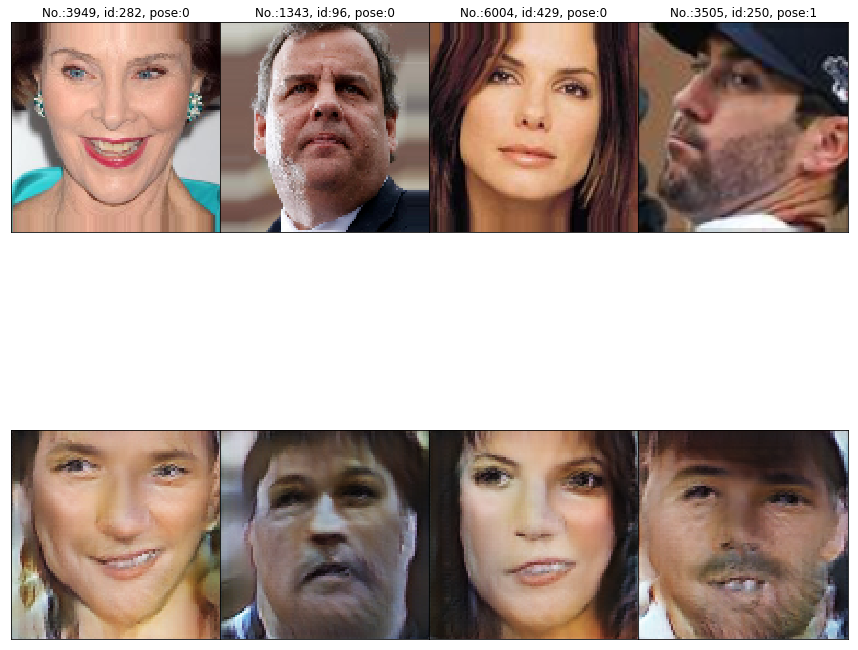

In [7]:
# 同一ポーズで複数の顔写真を生成テスト

import easydict

Np = 2
n = 4
pose = 1
image_list = np.random.randint(0,6900, (1,n))[0]
args = easydict.EasyDict({
    "cuda": False,
})
generated_image = Generate_Image(images[image_list], pose, Np, 50, G, args)

plt.rcParams['figure.figsize'] = (15.0, 15.0)
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.title('No.:{}, id:{}, pose:{}'.format(image_list[i], id_labels[image_list[i]], pose_labels[image_list[i]]))
    plt.imshow(jpg_image[image_list[i]])
    plt.subplot(2, n, n+i+1)
    plt.imshow(generated_image[i])

axes = plt.gcf().get_axes()
for ax in axes:
    ax.tick_params(labelbottom="off",bottom="off") # x軸の削除
    ax.tick_params(labelleft="off",left="off") # y軸の削除
    ax.set_xticklabels([]) 
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
plt.show()


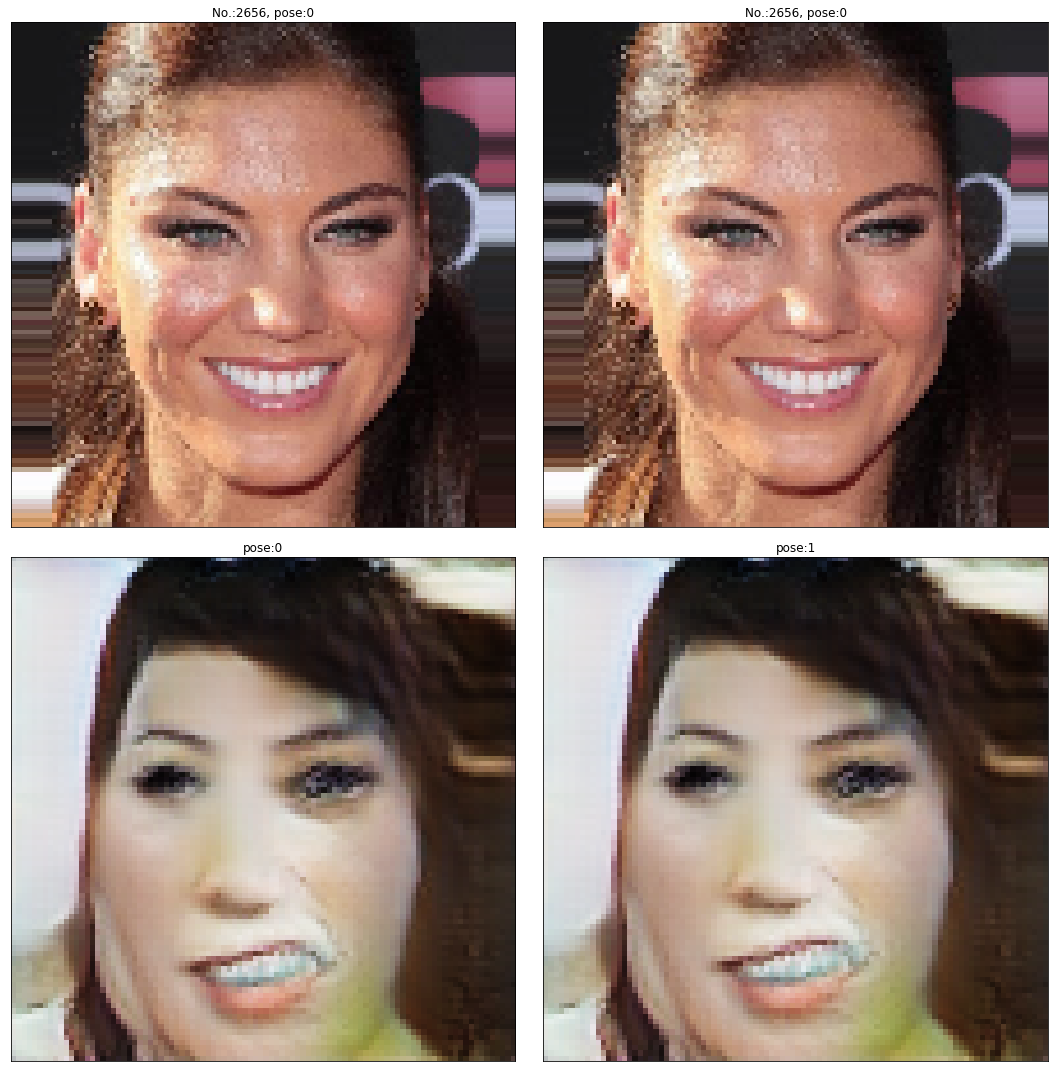

In [8]:
# 同一写真で複数のポーズを生成テスト

Np = 2
n = 1
image_list = np.random.randint(0,6900, (1,n))[0]


generated_image = []

for i in range(Np):
        pose = i
        generated_image_pose = Generate_Image(images[image_list], pose, Np,  50, G , args)
        generated_image.append(generated_image_pose)

plt.rcParams['figure.figsize'] = (15.0, 15.0)
for i in range(Np):
    plt.subplot(2, Np, i+1)
    plt.title('No.:{}, pose:{}'.format(image_list[0], pose_labels[image_list[0]]))
    plt.imshow(jpg_image[image_list[0]])
    
    plt.subplot(2, Np, i+1+Np)
    plt.title('pose:{}'.format(i))
    plt.imshow(generated_image[i].squeeze())

axes = plt.gcf().get_axes()
for ax in axes:
    ax.tick_params(labelbottom="off",bottom="off") # x軸の削除
    ax.tick_params(labelleft="off",left="off") # y軸の削除
    ax.set_xticklabels([]) 

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
fig = plt.gcf()
fig.tight_layout()
plt.show()
